# Automated Extraction of Quotations From Text - Hyperparameter Tuning

The purpose is to tune the hyperparameters of the RNN model by doing a Random Search for the  parameters to produce the best results. The model is then retrained using the best parameters and saved for deployment later.

## Prepare Data

### Load Libraries

In [ ]:
!pip install --quiet keras-tuner

In [ ]:
import pandas as pd
import numpy as np

# import sklearn
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix
# from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model, Sequential

import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import re
import nltk
import gensim
import gensim.downloader as api

from datetime import datetime
import pickle

from kerastuner.tuners import RandomSearch

In [ ]:
# from google.colab import files

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Load Data

In [ ]:
df = pd.read_csv('quotes-prepared-40000.csv')

In [ ]:
df.rename(columns={"quote": "category"}, inplace=True)
df = df[["category", "text"]]

# Show the data
df.head()

,category,text
0,1,Color is an intense experience on its own.
1,1,God takes great joy in the passionate romantic...
2,1,"No jealousy their dawn of love overcast, nor b..."
3,0,The sound mockery of sheep is like the salubri...
4,1,Players have two things to do: Play and keep t...


### Proprocess Data

In [ ]:
# Use stopwords list from nltk (that is used in the function below)
lst_stopwords = nltk.corpus.stopwords.words("english")

def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    # Clean (convert to lowercase and remove punctuations and characters and then strip)
    # The function is not optimized for speed but split into various steps for pedagogical purpose
    text = str(text).lower()
    text = text.strip()
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize (convert from string to list)
    lst_text = text.split()
    # remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in lst_stopwords]

    # Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]

    # Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]

    # back to string from list
    text = " ".join(lst_text)
    return text

In [ ]:
# Let's apply this function to the whole corpus
df["text_clean"] = df["text"].apply(lambda x: utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, lst_stopwords=lst_stopwords))

# Let's look at the output
df.head()

,category,text,text_clean
0,1,Color is an intense experience on its own.,color intense experience
1,1,God takes great joy in the passionate romantic...,god take great joy passionate romantic love hu...
2,1,"No jealousy their dawn of love overcast, nor b...",jealousy dawn love overcast blasted wedded day...
3,0,The sound mockery of sheep is like the salubri...,sound mockery sheep like salubrious horse laugh
4,1,Players have two things to do: Play and keep t...,player two thing play keep mouth shut


### Test Data

In [ ]:
text_test = [
  'A journey of a thousand miles begins with a single step.',
  'Are you beginning a journey of a thousand steps tomorrow?',
  'The Post cited people familiar with the investigation as saying that federal agents were looking for classified documents related to nuclear weapons',
  'But it turns out that Trump did take such material from the White House.',
  'No one will reap except what they sow.'
]

truth_test = [1, 0, 0, 0, 1]

### Functions

In [ ]:
def sns_cm(cm, score):
  plt.figure(figsize=(9,9))
  sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
  plt.ylabel('Actual label');
  plt.xlabel('Predicted label');
  all_sample_title = 'Accuracy Score: {0}'.format(score)
  plt.title(all_sample_title, size = 15);

In [ ]:
def precision_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

In [ ]:
def recall_m(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

## RNN Model

### Split Data

In [ ]:
X_tf = df['text']
y_tf = df['category']

X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=0.3, random_state=42, stratify=df['category'])

In [ ]:
corpus = X_tf_train
max_words = 30000
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

### Explore Data

In [ ]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n = 10
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])

Shape:  (20720, 200)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0 

### Pretrained Model

In [ ]:
w2v = api.load("word2vec-google-news-300")
w2v['example'].shape

(300,)

In [ ]:
assert max_words >= len(reverse_voc)

In [ ]:
emb_matrix=np.zeros((max_words+1, 300))

for i in range(len(reverse_voc)):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

## Hyperparameter Tuning

### Build Model

In [ ]:
def model_builder(hp):
  model = Sequential()

  lstm = hp.Int('lstm', min_value=5, max_value=30, step=5, default=15)
  units = hp.Int('units', min_value=32, max_value=128, step=32, default=64)
  dropout = hp.Float('dropout', min_value=0.2, max_value=0.8, step=0.1, default=0.5)
  
  # hp_learning_rate = hp.Choice('learning_rate', values=[0.01, 0.003, 0.001, 0.0003, 0.0001, 0.00003])
  learning_rate = 0.01
  beta_1 = 0.9

  input_ = layers.Input(shape = X_tf_train_seq[0,:].shape,name='input')
  x = layers.Embedding(max_words+1,emb_size,weights=[emb_matrix],trainable=False, name='embedding')(input_)
  x = layers.Bidirectional(layers.LSTM(lstm, dropout=dropout),name='bidirectional-lstm')(x) # LSTM layer
  x = layers.Dropout(dropout, name='dropout')(x)
  x = layers.Dense(units, activation='relu', name='dense')(x)
  output = layers.Dense(1 ,activation='sigmoid', name='classification')(x)

  model = models.Model(input_, output)

  opt = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1)
  model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy', precision_m, recall_m])

  return model

### Random Search

In [ ]:
RandomSearch?

In [ ]:
tuner = RandomSearch(
    model_builder,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='./randomsearch',
    overwrite = True,
    project_name='RNN Random Search')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
lstm (Int)
{'default': 15, 'conditions': [], 'min_value': 5, 'max_value': 30, 'step': 5, 'sampling': None}
units (Int)
{'default': 64, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.5, 'conditions': [], 'min_value': 0.2, 'max_value': 0.8, 'step': 0.1, 'sampling': None}


In [ ]:
tuner.search(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data = (X_tf_test_seq, y_tf_test))

Trial 10 Complete [00h 12m 26s]
val_accuracy: 0.857207179069519

Best val_accuracy So Far: 0.8811936974525452
Total elapsed time: 01h 44m 50s
Trial 10 Complete [00h 12m 26s]
val_accuracy: 0.857207179069519

Best val_accuracy So Far: 0.8811936974525452
Total elapsed time: 01h 44m 50s


### Search Results

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
best_hps.values

{'lstm': 25, 'units': 64, 'dropout': 0.4000000000000001}

{'lstm': 25, 'units': 64, 'dropout': 0.4000000000000001}

In [ ]:
tuner.results_summary()

Results summary
Results in ./randomsearch/RNN Random Search
Showing 10 best trials
Trial summary
Hyperparameters:
lstm: 25
units: 64
dropout: 0.4000000000000001
Score: 0.8811936974525452
Trial summary
Hyperparameters:
lstm: 15
units: 96
dropout: 0.30000000000000004
Score: 0.8773648738861084
Trial summary
Hyperparameters:
lstm: 20
units: 32
dropout: 0.6000000000000001
Score: 0.8752252459526062
Trial summary
Hyperparameters:
lstm: 10
units: 96
dropout: 0.5000000000000001
Score: 0.8745495676994324
Trial summary
Hyperparameters:
lstm: 20
units: 96
dropout: 0.6000000000000001
Score: 0.8724098801612854
Trial summary
Hyperparameters:
lstm: 15
units: 64
dropout: 0.6000000000000001
Score: 0.8697072267532349
Trial summary
Hyperparameters:
lstm: 10
units: 96
dropout: 0.6000000000000001
Score: 0.8692567348480225
Trial summary
Hyperparameters:
lstm: 10
units: 32
dropout: 0.7000000000000002
Score: 0.8626126050949097
Trial summary
Hyperparameters:
lstm: 10
units: 64
dropout: 0.7000000000000002
Score:

### Best Epoch

In [ ]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))

Epoch 1/10
Epoch 1/10
324/324 [==============================] - 74s 219ms/step - loss: 0.4078 - accuracy: 0.8208 - precision_m: 0.8210 - recall_m: 0.8183 - val_loss: 0.3376 - val_accuracy: 0.8586 - val_precision_m: 0.8957 - val_recall_m: 0.8103
Epoch 2/10
Epoch 2/10
324/324 [==============================] - 71s 218ms/step - loss: 0.3518 - accuracy: 0.8535 - precision_m: 0.8505 - recall_m: 0.8606 - val_loss: 0.3038 - val_accuracy: 0.8738 - val_precision_m: 0.8804 - val_recall_m: 0.8642
Epoch 3/10
Epoch 3/10
324/324 [==============================] - 71s 219ms/step - loss: 0.3255 - accuracy: 0.8666 - precision_m: 0.8642 - recall_m: 0.8712 - val_loss: 0.3030 - val_accuracy: 0.8757 - val_precision_m: 0.8739 - val_recall_m: 0.8762
Epoch 4/10
Epoch 4/10
324/324 [==============================] - 71s 219ms/step - loss: 0.3048 - accuracy: 0.8732 - precision_m: 0.8675 - recall_m: 0.8823 - val_loss: 0.3030 - val_accuracy: 0.8742 - val_precision_m: 0.8981 - val_recall_m: 0.8419
Epoch 5/10
Epoch

In [ ]:
val_acc_per_epoch = history.history['val_recall_m']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 8


### Rebuild Model

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

In [ ]:
start_time = datetime.now()

# Retrain the model
history = hypermodel.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=best_epoch, validation_split=0.2)
end_time = datetime.now()

training_time_rnn = (end_time - start_time).total_seconds()

Epoch 1/8
259/259 [==============================] - 55s 202ms/step - loss: 0.4227 - accuracy: 0.8132 - precision_m: 0.8094 - recall_m: 0.8257 - val_loss: 0.3376 - val_accuracy: 0.8663 - val_precision_m: 0.8459 - val_recall_m: 0.8933
Epoch 2/8
259/259 [==============================] - 53s 204ms/step - loss: 0.3581 - accuracy: 0.8512 - precision_m: 0.8480 - recall_m: 0.8588 - val_loss: 0.3226 - val_accuracy: 0.8704 - val_precision_m: 0.8679 - val_recall_m: 0.8720
Epoch 3/8
259/259 [==============================] - 52s 202ms/step - loss: 0.3373 - accuracy: 0.8574 - precision_m: 0.8534 - recall_m: 0.8667 - val_loss: 0.3200 - val_accuracy: 0.8723 - val_precision_m: 0.8911 - val_recall_m: 0.8478
Epoch 4/8
259/259 [==============================] - 51s 196ms/step - loss: 0.3145 - accuracy: 0.8680 - precision_m: 0.8675 - recall_m: 0.8713 - val_loss: 0.3097 - val_accuracy: 0.8699 - val_precision_m: 0.8417 - val_recall_m: 0.9104
Epoch 5/8
259/259 [==============================] - 51s 198ms/s

In [ ]:
eval_result = hypermodel.evaluate(X_tf_test_seq, y_tf_test)
print("[test loss, test accuracy]:", eval_result)

278/278 [==============================] - 10s 36ms/step - loss: 0.3246 - accuracy: 0.8694 - precision_m: 0.8335 - recall_m: 0.9226
[test loss, test accuracy]: [0.32461482286453247, 0.869369387626648, 0.8335002660751343, 0.922552227973938]


## Best Model

In [ ]:
hypermodel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          9000300   
                                                                 
 bidirectional-lstm (Bidirec  (None, 50)               65200     
 tional)                                                         
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 64)                3264      
                                                                 
 classification (Dense)      (None, 1)                 65        
                                                           

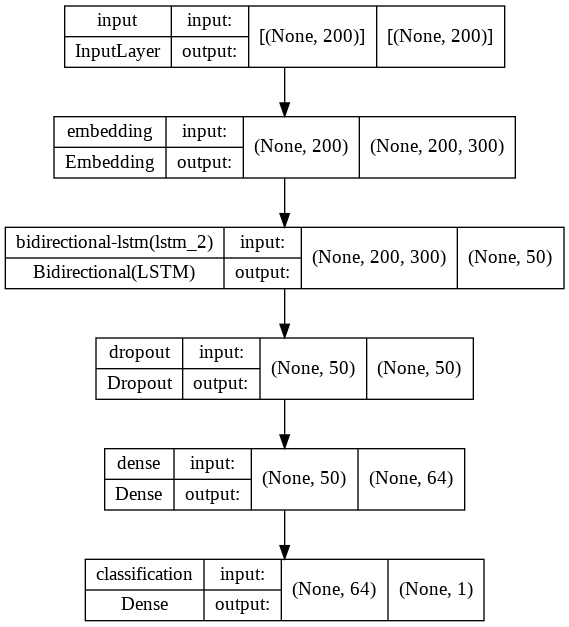

In [ ]:
plot_model(hypermodel, show_shapes=True)

### Evaluate Model

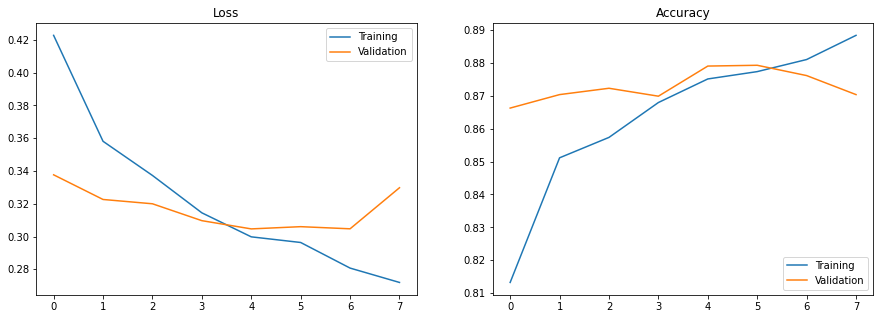

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history.history['loss'], label='Training')
ax[0].plot(history.history['val_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history.history['accuracy'], label='Training')
ax[1].plot(history.history['val_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [ ]:
pd.DataFrame(history.history)

,loss,accuracy,precision_m,recall_m,val_loss,val_accuracy,val_precision_m,val_recall_m
0,0.422731,0.813224,0.809433,0.825704,0.337646,0.866313,0.845860,0.893286
1,0.358097,0.851170,0.848037,0.858792,0.322598,0.870415,0.867901,0.872000
2,0.337256,0.857384,0.853378,0.866658,0.319972,0.872346,0.891128,0.847832
3,0.314452,0.868002,0.867538,0.871303,0.309669,0.869932,0.841745,0.910377
4,0.299797,0.875181,0.870363,0.884252,0.304644,0.879102,0.892635,0.862144
5,0.296355,0.877413,0.877524,0.879990,0.306004,0.879344,0.873513,0.886163
6,0.280734,0.881093,0.877322,0.888151,0.304701,0.876207,0.853616,0.909133
7,0.271974,0.888453,0.885205,0.895093,0.329759,0.870415,0.834657,0.923644


In [ ]:
accuracy_rnn = history.history['val_accuracy'][-1]
print('Accuracy Training data: {:.1%}'.format(history.history['accuracy'][-1]))
print('Accuracy Test data: {:.1%}'.format(history.history['val_accuracy'][-1]))
print('Training time: {:.1f}s'.format(training_time_rnn))

Accuracy Training data: 88.8%
Accuracy Test data: 87.0%
Training time: 444.5s


### Confusion Matrix

In [ ]:
predicted_test_rnn = hypermodel.predict(X_tf_test_seq).reshape(-1)
predicted_test_rnn = [1 if prob > 0.5 else 0 for prob in predicted_test_rnn]

In [ ]:
cm_rnn = confusion_matrix(y_tf_test, predicted_test_rnn)
cm_rnn

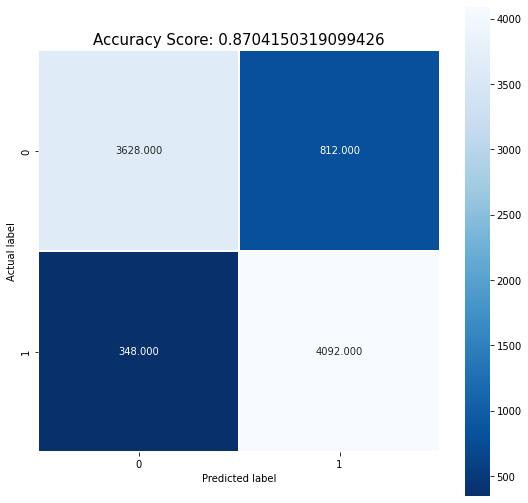

In [ ]:
sns_cm(cm_rnn, history.history['val_accuracy'][-1])

### Test Prediction

In [ ]:
text_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(text_test), maxlen=max_len)

In [ ]:
text_test_seq.shape

(5, 200)

In [ ]:
text_test_seq[0, :]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [ ]:
text_test_prob = hypermodel.predict(text_test_seq).reshape(-1)
text_test_prob

array([0.9706421 , 0.99517286, 0.00239542, 0.11195478, 0.892553  ],
      dtype=float32)

In [ ]:
text_test_prediction = [1 if prob > 0.5 else 0 for prob in text_test_prob]
text_test_prediction

[1, 1, 0, 0, 1]

In [ ]:
pd.DataFrame(data={
    'Text': text_test,
    'Probability': text_test_prob,
    'Prediction': text_test_prediction,
    'Truth': truth_test
})

,Text,Probability,Prediction,Truth
0,A journey of a thousand miles begins with a si...,0.970642,1,1
1,Are you beginning a journey of a thousand step...,0.995173,1,0
2,The Post cited people familiar with the invest...,0.002395,0,0
3,But it turns out that Trump did take such mate...,0.111955,0,0
4,No one will reap except what they sow.,0.892553,1,1


### Save Model

In [ ]:
pickle.dump(corpus, open('corpus.model', 'wb'))
# files.download('corpus.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
hypermodel.save('rnn2.h5')
# files.download('rnn2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Load and test the saved model.

In [ ]:
hypermodel2 = load_model('rnn2.h5', custom_objects={'precision_m': precision_m, 'recall_m': recall_m})
text_test_prob2 = hypermodel2.predict(text_test_seq).reshape(-1)
text_test_prob2

array([0.9706421 , 0.99517286, 0.00239542, 0.11195478, 0.892553  ],
      dtype=float32)